# Каскады Хаара

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Чтение изображения
original_image = cv.imread("face1.jpeg")

# Конвертация изображения в градации серого
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)

In [3]:
# Загрузка классификатора и создание каскадного объекта для распознавания лиц (указан путь к модели в вашей папке с данным ноутбуком)
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')

In [4]:
face_cascade

< cv2.CascadeClassifier 0x7f1e818f4990>

In [5]:
detected_faces = face_cascade.detectMultiScale(grayscale_image)

In [6]:
for (column, row, width, height) in detected_faces:
    cv.rectangle(
        original_image,
        (column, row),
        (column + width, row + height),
        (0, 255, 0),
        2
    )

In [7]:
detected_faces

array([[164,  98, 500, 500]], dtype=int32)

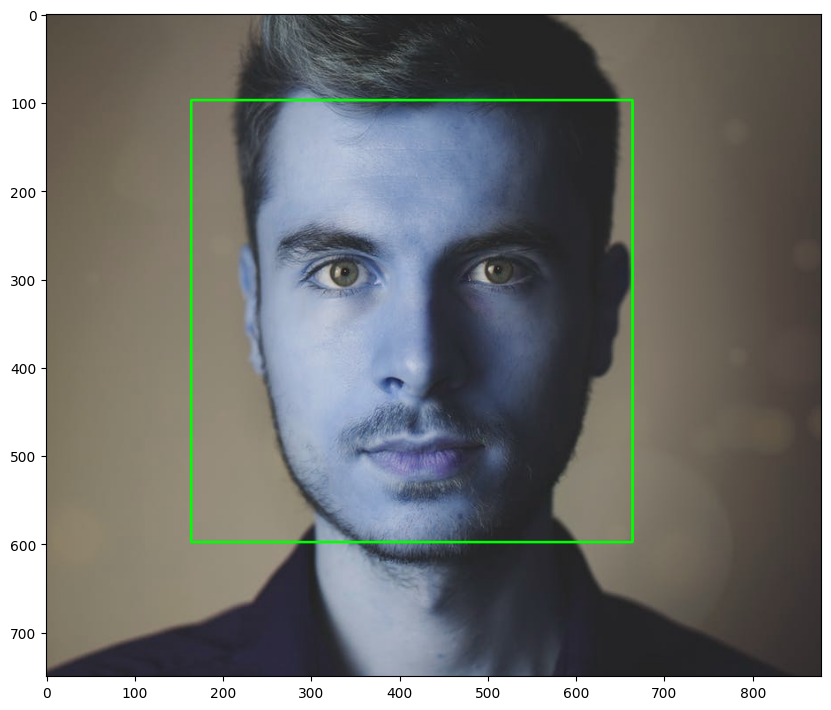

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.show()

# ДЗ: Напишите класс, который при инициализации должен принимать на вход путь к "*.xml" файлу обученной модели каскадов Хаара. Класс должен содержать функционал для загрузки изображения и вывода, с помощью этой обученной модели, результата распознавания лиц на изображении. Также в подписи к названию результата необходимо добавить количество задетектированных лиц. Приведите как минимум два примера работы такого класса.

In [17]:
path_to_image1 = "family.JPG"
path_to_image2 = "startrek.png"

In [9]:
class FaceDetector:
    def __init__(self, model_path):
        """
        Инициализация детектора лиц с использованием указанного xml-файла модели
        :param model_path: путь к xml файлу обученной модели
        """
        self.face_cascade = cv.CascadeClassifier(model_path)

    def load_and_detect(self, image_path):
        """
        Загружает изображение, выполняет детекцию лиц и отображает результат
        :param image_path: путь к изображению
        """
        # Чтение изображения
        original_image = cv.imread(image_path)
        if original_image is None:
            raise ValueError("Не удалось загрузить изображение. Проверьте путь")
        
        # Конвертация в оттенки серого
        grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
        
        # Детекция лиц
        detected_faces = self.face_cascade.detectMultiScale(grayscale_image)
        
        # Отрисовка рамок вокруг обнаруженных лиц
        for (column, row, width, height) in detected_faces:
            cv.rectangle(
                original_image,
                (column, row),
                (column + width, row + height),
                (0, 255, 0),
                2
            )
        
        # Отображение изображения с детектированными лицами
        plt.figure(figsize=(10, 10))
        plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
        plt.title(f'Обнаружено лиц: {len(detected_faces)}')
        plt.axis('off')
        plt.show()

In [15]:
detector = FaceDetector('haarcascade_frontalface_alt.xml')

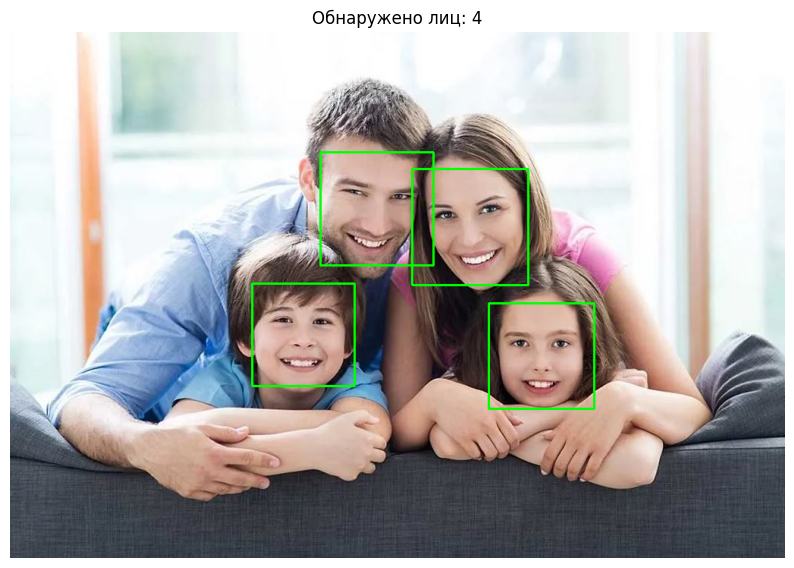

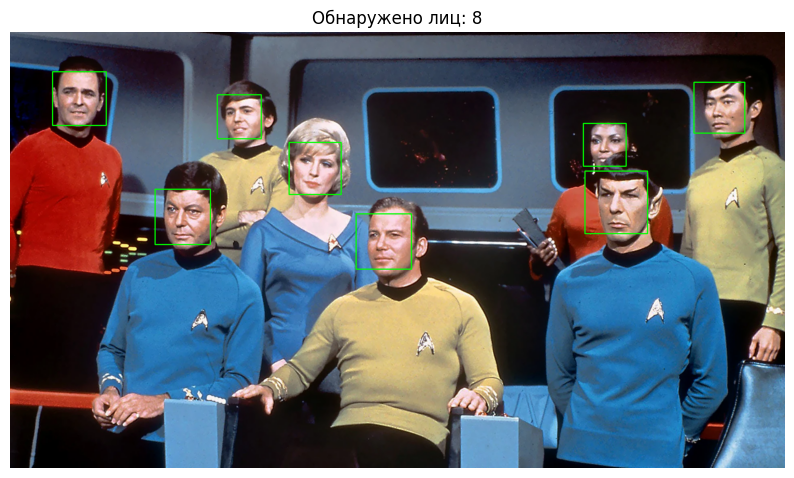

In [18]:
detector.load_and_detect(path_to_image1)
detector.load_and_detect(path_to_image2)

# ДЗ на дополнительные баллы *: срок больше основного дедлайна по ДЗ (вместо 19.01.25 до 23.01.25)
# Каскады Хаара могут себя хорошо показать при обнаружении лиц на изображениях. Напишите код для разложения короткого (несколько секунд) видео с людьми на кадры, каждый кадр обработайте и отрисуйте на нем задетектированные лица с помощью каскадов, и соберите результат в одно видео обратно.

Ниже представлен примерный код для работы по разложению видео на кадры и обратной его сборки из кадров.
- Дополнительный ссылки - https://medium.com/@haydenfaulkner/extracting-frames-fast-from-a-video-using-opencv-and-python-73b9b7dc9661
- decord - https://github.com/dmlc/decord

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import cv2
import multiprocessing
import os
import sys

def print_progress(iteration, total, prefix='', suffix='', decimals=3, bar_length=100):
    """
    Print progress bar to the console.
    """
    format_str = "{0:." + str(decimals) + "f}"
    percents = format_str.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '#' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f'\r{prefix} |{bar}| {percents}% {suffix}')
    sys.stdout.flush()

def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using OpenCV's VideoCapture.
    """
    video_path = os.path.normpath(video_path)
    frames_dir = os.path.normpath(frames_dir)

    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    video_dir, video_filename = os.path.split(video_path)
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)

    capture = cv2.VideoCapture(video_path)

    if start < 0:
        start = 0
    if end < 0:
        end = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    saved_count = 0

    for frame in range(start, end):
        ret, image = capture.read()

        if not ret:
            break

        if frame % every == 0:
            save_path = os.path.join(frames_dir, video_filename, f"{frame:010d}.jpg")
            if not os.path.exists(save_path) or overwrite:
                cv2.imwrite(save_path, image)
                saved_count += 1

    capture.release()
    return saved_count

def video_to_frames(video_path, frames_dir, overwrite=False, every=1, chunk_size=1000):
    """
    Extract frames from a video using multiprocessing.
    """
    video_path = os.path.normpath(video_path)
    frames_dir = os.path.normpath(frames_dir)

    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    video_dir, video_filename = os.path.split(video_path)
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)

    capture = cv2.VideoCapture(video_path)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    capture.release()

    if total_frames < 1:
        raise ValueError("Video has no frames. Check your OpenCV installation.")

    frame_chunks = [[i, min(i + chunk_size, total_frames)] for i in range(0, total_frames, chunk_size)]
    prefix_str = f"Extracting frames from {video_filename}"

    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        futures = [executor.submit(extract_frames, video_path, frames_dir, overwrite, chunk[0], chunk[1], every)
                   for chunk in frame_chunks]

        for i, f in enumerate(as_completed(futures)):
            print_progress(i, len(frame_chunks), prefix=prefix_str, suffix='Complete')

    return os.path.join(frames_dir, video_filename)

def frames_to_video(frames_dir, output_path, fps=30, reverse=False):
    """
    Create a video from a sequence of frames.
    """
    frames_dir = os.path.normpath(frames_dir)
    output_path = os.path.normpath(output_path)

    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".jpg")])
    if reverse:
        frame_files = frame_files[::-1]

    if not frame_files:
        raise ValueError("No frames found in the directory.")

    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    height, width, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Video saved to {output_path}")

if __name__ == '__main__':
    # Test frame extraction
    frames_dir = video_to_frames(video_path='test.mp4', frames_dir='test_frames', overwrite=False, every=5, chunk_size=1000)

    # Test video assembly
    frames_to_video(frames_dir=frames_dir, output_path='output.mp4', fps=30, reverse=False)

    # Test reverse video
    frames_to_video(frames_dir=frames_dir, output_path='output_reversed.mp4', fps=30, reverse=True)
